gpu üstünde çalışmak

In [1]:
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive

Mounted at /gdrive
/gdrive


Kütüphane Kurulumları

In [2]:
from keras.layers import Input , Dense , Conv2D , MaxPooling2D , UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt


# Veri Kümesini Oluşturmak Ve Ayırmak

In [3]:
(x_train , _) , (x_test , _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.reshape(x_train , (len(x_train) , 28 , 28 , 1 ))
x_test = np.reshape(x_test , (len(x_test) , 28 , 28 , 1 ))

In [5]:
print("Eğitim : " , x_train.shape)
print("Test :  " , x_test.shape)

Eğitim :  (60000, 28, 28, 1)
Test :   (10000, 28, 28, 1)


Veriye Gürültü Ekleme Adımı

In [6]:
noise_factor = 0.5 

x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0 , 
                                                          scale= 1.0 ,
                                                          size = x_train.shape)

x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0 , 
                                                          scale= 1.0 ,
                                                          size = x_test.shape)

x_train_noisy = np.clip(x_train_noisy , 0. , 1.)
x_test_noisy = np.clip(x_test_noisy , 0. , 1.)

Gürültülü Veriyi Görselleştirme

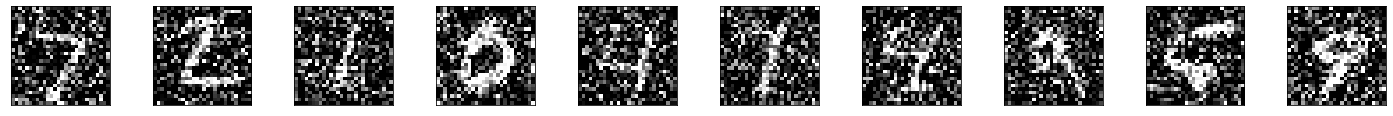

Gürültülü Orjinal Görüntüler


In [7]:
%matplotlib inline

n = 10 

plt.figure(figsize= ( 25 , 4))

for i in range(n):
    ax = plt.subplot(2 , n , i+1)
    plt.imshow(x_test_noisy[i].reshape(28 , 28 ))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
print("Gürültülü Orjinal Görüntüler")

ENCODE Modeli 

In [8]:
input_img = Input(shape= (28 , 28 , 1 ))

x= Conv2D( 32 , (3 , 3) , activation= "relu" , padding= "same" )(input_img)

x = MaxPooling2D((2 , 2 ) , padding= "same")(x)

x = Conv2D(32 , ( 3 , 3) , activation= "relu" , padding= "same")(x)

encoded = MaxPooling2D((2  , 2 ) , padding= "same" )(x)

#(7 ,7 , 32)


DECODE Modeli

In [9]:
x = Conv2D(32 , ( 3, 3), activation= "relu" , padding= "same")(encoded)

x = UpSampling2D((2 , 2))(x)

x = Conv2D(32 , ( 3, 3), activation= "relu" , padding= "same")(x)

x = UpSampling2D((2 , 2))(x)

decoded= Conv2D(1, ( 3 , 3) , activation= "sigmoid" , padding= "same")(x)


Modelin Derlenmesi ve Eğitilmesi

In [10]:
autoencoder = Model(input_img , decoded) 
autoencoder.compile(optimizer = "adadelta" , loss = "binary_crossentropy")

In [14]:
autoencoder.fit(x_train_noisy , x_train,
                epochs = 10,
                batch_size = 128,
                shuffle = True,
                validation_data = (x_test_noisy , x_test), 
                callbacks = [TensorBoard(log_dir= "/tmp/tb" ,
                                         histogram_freq= 0,
                                         write_graph = False ) ] )

decoded_imgs = autoencoder.predict(x_test)

Epoch 1/10
469/469 [==============================] - 144s 308ms/step - loss: 0.6342 - val_loss: 0.5982
Epoch 2/10
469/469 [==============================] - 143s 304ms/step - loss: 0.5546 - val_loss: 0.5267
Epoch 3/10
469/469 [==============================] - 143s 305ms/step - loss: 0.5153 - val_loss: 0.5139
Epoch 4/10
469/469 [==============================] - 144s 307ms/step - loss: 0.5066 - val_loss: 0.5069
Epoch 5/10
469/469 [==============================] - 144s 307ms/step - loss: 0.4998 - val_loss: 0.5002
Epoch 6/10
469/469 [==============================] - 143s 305ms/step - loss: 0.4932 - val_loss: 0.4935
Epoch 7/10
469/469 [==============================] - 144s 306ms/step - loss: 0.4865 - val_loss: 0.4867
Epoch 8/10
469/469 [==============================] - 144s 306ms/step - loss: 0.4796 - val_loss: 0.4796
Epoch 9/10
469/469 [==============================] - 144s 307ms/step - loss: 0.4724 - val_loss: 0.4720
Epoch 10/10
469/469 [==============================] - 145s 310m

Eğitim Sonrası

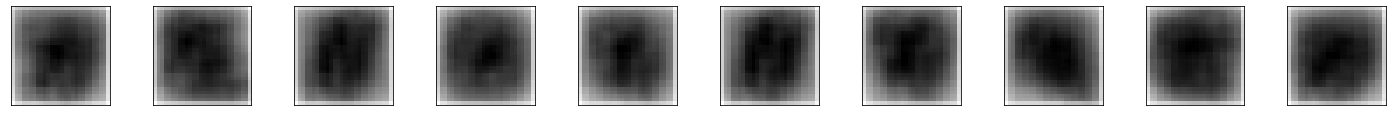

DENOISED - GÜRÜLTÜSÜ BASTIRILMIŞ Görüntüler


In [16]:
%matplotlib inline

n = 10 

plt.figure(figsize= ( 25 , 4))

for i in range(n):
    ax = plt.subplot(2 , n , i + 1)
    plt.imshow(decoded_imgs[i].reshape(28 , 28 ))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
print("DENOISED - GÜRÜLTÜSÜ BASTIRILMIŞ Görüntüler")